# Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
from numpy import asarray
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import glob
import os 
import random
import subprocess
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.patches import Rectangle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
#List the files in the dataset directory
dataset_path = '/kaggle/input/revitsone-5class'
os.listdir(dataset_path)

['Revitsone-5classes', 'revitsone-5classes']

# Data Preparation
## 1. 5 classes into 5 different variables

In [3]:
image_list_other = []
image_list_safe = []
image_list_talking = []
image_list_text = []
image_list_turn = []

for other in os.listdir("/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities"): 
    if other.endswith(".png") or other.endswith(".jpg"): 
        image_list_other.append(os.path.join("/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities",
                                             other))
        print(os.path.join("/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities", other))
        
for safe in os.listdir("/kaggle/input/revitsone-5class/Revitsone-5classes/safe_driving"): 
    if safe.endswith(".png") or safe.endswith(".jpg"): 
        image_list_safe.append(os.path.join("/kaggle/input/revitsone-5class/Revitsone-5classes/safe_driving", 
                                            safe))
        print(os.path.join("/kaggle/input/revitsone-5class/Revitsone-5classes/safe_driving",
                           safe))
        
for talking in os.listdir("/kaggle/input/revitsone-5class/Revitsone-5classes/talking_phone"): 
    if talking.endswith(".png") or talking.endswith(".jpg"): 
        image_list_talking.append(os.path.join("/kaggle/input/revitsone-5class/Revitsone-5classes/talking_phone", 
                                               talking))
        print(os.path.join("/kaggle/input/revitsone-5class/Revitsone-5classes/talking_phone",
                           talking))
        
for text in os.listdir("/kaggle/input/revitsone-5class/Revitsone-5classes/texting_phone"): 
    if text.endswith(".png") or text.endswith(".jpg"): 
        image_list_text.append(os.path.join("/kaggle/input/revitsone-5class/Revitsone-5classes/texting_phone",
                                            text))
        print(os.path.join("/kaggle/input/revitsone-5class/Revitsone-5classes/texting_phone",
                           text))
        
for turn in os.listdir("/kaggle/input/revitsone-5class/Revitsone-5classes/turning"): 
    if turn.endswith(".png") or turn.endswith(".jpg"): 
        image_list_turn.append(os.path.join("/kaggle/input/revitsone-5class/Revitsone-5classes/turning",
                                            turn))
        print(os.path.join("/kaggle/input/revitsone-5class/Revitsone-5classes/turning", 
                           turn))
    
    

/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_25688.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_10731.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_19798.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_4207.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_24816.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_5355.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_4541.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_6690.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_3114.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_12714.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_17534.jpg
/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_12892.jpg
/kaggle/input/revitsone-5class/Re

## 2. Delete unreadable images

In [4]:
image_list_other.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_79.jpg')
image_list_other.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_4664.jpg')
image_list_other.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_7973.jpg')
image_list_other.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_13318.jpg')
image_list_other.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_13396.jpg')
image_list_other.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_13541.jpg')
image_list_other.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_13625.jpg')
image_list_other.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_20398.jpg')
image_list_other.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/other_activities/img_22266.jpg')

image_list_turn.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/turning/img_8771.jpg')
image_list_turn.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/turning/img_62337.jpg')
image_list_turn.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/turning/img_67523.jpg')
image_list_turn.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/turning/img_70552.jpg')
image_list_turn.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/turning/img_84605.jpg')
image_list_turn.remove('/kaggle/input/revitsone-5class/Revitsone-5classes/turning/img_101434.jpg')

In [5]:
font = {'family':'Times New Roman','color':'#1f211f'}
background_color = '#fab72f'

## 3. Spilt data to test, train and prediction

In [6]:
#Check the total amount of each classes
print("Number of samples in (Class = Other) = " ,len(image_list_other))
print("Number of samples in (Class = Safe Driving) = " ,len(image_list_safe))
print("Number of samples in (Class = Talking Phone) = " ,len(image_list_talking))
print("Number of samples in (Class = Texting Phone) = " ,len(image_list_text))
print("Number of samples in (Class = Turning) = " ,len(image_list_turn))

Number of samples in (Class = Other) =  2119
Number of samples in (Class = Safe Driving) =  2203
Number of samples in (Class = Talking Phone) =  2169
Number of samples in (Class = Texting Phone) =  2203
Number of samples in (Class = Turning) =  2057


In [7]:
#Spilt dataset into (train, test, prediction)=(0.75, 0.25, 0.05)
print(.75*len(image_list_other) , .2*len(image_list_other) ,.05*len(image_list_other))
print(.75*len(image_list_safe) , .2*len(image_list_safe) ,.05*len(image_list_safe))
print(.75*len(image_list_talking) , .2*len(image_list_talking) ,.05*len(image_list_talking))
print(.75*len(image_list_text) , .2*len(image_list_text) ,.05*len(image_list_text))
print(.75*len(image_list_turn) , .2*len(image_list_turn) ,.05*len(image_list_turn))

1589.25 423.8 105.95
1652.25 440.6 110.15
1626.75 433.8 108.45
1652.25 440.6 110.15
1542.75 411.40000000000003 102.85000000000001


In [8]:
print("Train","Test", "Valid")

#Locate 'other' class
train_other = image_list_other[:1589]
test_other = image_list_other[1589:2012]
valid_other = image_list_other[2012:]

print (len(train_other), len(test_other), len(valid_other))

#Locate 'safe' class
train_safe = image_list_safe[:1652]
test_safe = image_list_safe[1652:2092]
valid_safe = image_list_safe[2092:]

print (len(train_safe), len(test_safe), len(valid_safe))

#Locate 'talking' class
train_talking = image_list_talking[:1626]
test_talking = image_list_talking[1626:2059]
valid_talking = image_list_talking[2059:]

print (len(train_talking), len(test_talking), len(valid_talking))

#Locate 'text' class
train_text = image_list_text[:1652]
test_text = image_list_text[1652:2092]
valid_text = image_list_text[2092:]

print (len(train_text), len(test_text), len(valid_text))

#Locate 'turn' class
train_turn = image_list_turn[:1547]
test_turn = image_list_turn[1547:1959]
valid_turn = image_list_turn[1959:]

print (len(train_turn), len(test_turn), len(valid_turn))

Train Test Valid
1589 423 107
1652 440 111
1626 433 110
1652 440 111
1547 412 98


## 4. Create dataframe for training, testing and prediction

In [9]:
# Train Dataframe
train_other_df = pd.DataFrame({'image':train_other, 'label':'Other'})
train_safe_df = pd.DataFrame({'image':train_safe, 'label':'Safe'})
train_talking_df = pd.DataFrame({'image':train_talking, 'label':'Talk'})
train_text_df = pd.DataFrame({'image':train_text, 'label':'Text'})
train_turn_df = pd.DataFrame({'image':train_turn, 'label':'Turn'})

In [10]:
# Test Dataframe
test_other_df = pd.DataFrame({'image':test_other, 'label':'Other'})
test_safe_df = pd.DataFrame({'image':test_safe, 'label':'Safe'})
test_talking_df = pd.DataFrame({'image':test_talking, 'label':'Talk'})
test_text_df = pd.DataFrame({'image':test_text, 'label':'Text'})
test_turn_df = pd.DataFrame({'image':test_turn, 'label':'Turn'})

In [11]:
# Prediction Dataframe
valid_other_df = pd.DataFrame({'image':valid_other, 'label':'Other'})
valid_safe_df = pd.DataFrame({'image':valid_safe, 'label':'Safe'})
valid_talking_df = pd.DataFrame({'image':valid_talking, 'label':'Talk'})
valid_text_df = pd.DataFrame({'image':valid_text, 'label':'Text'})
valid_turn_df = pd.DataFrame({'image':valid_turn, 'label':'Turn'})

In [12]:
# Concatenate multiple DataFrames into single DataFrames
train_df = pd.concat([train_other_df, train_safe_df, train_talking_df, train_text_df, train_turn_df])
test_df = pd.concat([test_other_df, test_safe_df, test_talking_df, test_text_df, test_turn_df])
val_df = pd.concat([valid_other_df, valid_safe_df, valid_talking_df, valid_text_df, valid_turn_df])

In [13]:
# Check train_df
train_df.head()

,image,label
0,/kaggle/input/revitsone-5class/Revitsone-5clas...,Other
1,/kaggle/input/revitsone-5class/Revitsone-5clas...,Other
2,/kaggle/input/revitsone-5class/Revitsone-5clas...,Other
3,/kaggle/input/revitsone-5class/Revitsone-5clas...,Other
4,/kaggle/input/revitsone-5class/Revitsone-5clas...,Other


In [14]:
print("Number of rows in train dataframe is: ", len(train_df))
print("Number of rows in test dataframe is: ", len(test_df))
print("Number of rows in val dataframe is: ", len(val_df))

Number of rows in train dataframe is:  8066
Number of rows in test dataframe is:  2148
Number of rows in val dataframe is:  537


## 5. Calculate images size (ratio)

In [15]:
random_img_height = random.choice(train_other)

image= cv2.imread(random_img_height)

height, width= image.shape[:2]

print("The height is ", height)

print("The width is ", width)

The height is  480
The width is  640


## 6. Define Hyperparameters
#### Before starting the model, some hyperparameters should be considered. I set the batch size to 64, but you can use 32 or other common values. You can also use functions to find the optimal number, though this can be time-consuming. For AlexNet, ResNet, and VGGNet, it's common to use a height and width of 240x240.

In [16]:
Batch_size = 64
Img_height = 240
Img_width = 240

## 7. Rescale the images (colors)

In [17]:
trainGenerator = ImageDataGenerator(rescale=1./255.)
valGenerator = ImageDataGenerator(rescale=1./255.)
testGenerator = ImageDataGenerator(rescale=1./255.)

## 8. Input flow from dataframe
### Which is the function from Tensorflow - Kera

In [18]:
trainDataset = trainGenerator.flow_from_dataframe(
  dataframe=train_df,
  class_mode="categorical",
  x_col="image",
  y_col="label",
  batch_size=Batch_size,
  seed=42,
  shuffle=True,
  target_size=(Img_height,Img_width) #set the height and width of the images
)

testDataset = testGenerator.flow_from_dataframe(
  dataframe=test_df,
  class_mode='categorical',
  x_col="image",
  y_col="label",
  batch_size=Batch_size,
  seed=42,
  shuffle=True,
  target_size=(Img_height,Img_width)
)

valDataset = valGenerator.flow_from_dataframe(
  dataframe=val_df,
  class_mode='categorical',
  x_col="image",
  y_col="label",
  batch_size=Batch_size,
  seed=42,
  shuffle=True,
  target_size=(Img_height,Img_width)
)

Found 8066 validated image filenames belonging to 5 classes.
Found 2148 validated image filenames belonging to 5 classes.
Found 537 validated image filenames belonging to 5 classes.


# AlexNet (Tensorflow)

In [ ]:
def AlexNet():
    inp = layers.Input((240, 240, 3))
    x = layers.Conv2D(96, 11, 4, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.Conv2D(256, 5, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.Conv2D(384, 3, 1, activation='relu')(x)
    x = layers.Conv2D(384, 3, 1, activation='relu')(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.MaxPooling2D(3, 2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(5, activation='softmax')(x)

    model_Alex = models.Model(inputs=inp, outputs=x)

    return model_Alex

model_Alex = AlexNet()
model_Alex.summary()

In [ ]:
tf.keras.utils.plot_model(
    model_Alex,
    to_file='alex_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [ ]:
model_Alex.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
Alex_model = model_Alex.fit(trainDataset, epochs=30, validation_data=valDataset)

# AlexNet Output Visualization

In [ ]:
training_loss_alex = Alex_model.history['loss']
val_loss_alex = Alex_model.history['val_loss']
training_acc_alex = Alex_model.history['accuracy']
val_acc_alex = Alex_model.history['val_accuracy']

In [ ]:
epoch_count = range(1, len(training_loss_alex) + 1)

# Visualize loss history
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, training_loss_alex, 'r--', color= 'navy')
plt.plot(epoch_count, val_loss_alex, '--bo',color= 'orangered', linewidth = '2.5', label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.title('Number of epochs & Loss in ALEXNET')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(1,21,1))
plt.show();

In [ ]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, training_acc_alex, 'r--', color= 'navy')
plt.plot(epoch_count, val_acc_alex, '--bo',color= 'orangered', linewidth = '2.5', label='line with marker')
plt.legend(['Training Acc', 'Val Acc'])
plt.title('Number of epochs & Accuracy in ALEXNET')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.xticks(np.arange(1,21,1))
plt.plot();
plt.show();

# VGGNet

In [ ]:
def VGGNet():
    inp = layers.Input((240, 240, 3))
    x = layers.Conv2D(64, 3, 1, activation='relu')(inp)
    x = layers.Conv2D(64, 3, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(128, 3, 1, activation='relu')(x)
    x = layers.Conv2D(128, 3, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.Conv2D(256, 3, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Conv2D(512, 3, 1, activation='relu')(x)
    x = layers.Conv2D(512, 3, 1, activation='relu')(x)
    x = layers.Conv2D(512, 3, 1, activation='relu')(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(5, activation='softmax')(x)

    model_VGG = models.Model(inputs=inp, outputs=x)

    return model_VGG

model_VGG = VGGNet()
model_VGG.summary()

In [ ]:
tf.keras.utils.plot_model(
    model_VGG,
    to_file='vgg_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [ ]:
model_VGG.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
VGG_model = model_VGG.fit(trainDataset, epochs=5, validation_data=valDataset)

# VGGNet Output Visualization

In [ ]:
training_loss_vgg = VGG_model.history['loss']
val_loss_vgg = VGG_model.history['val_loss']
training_acc_vgg = VGG_model.history['accuracy']
val_acc_vgg = VGG_model.history['val_accuracy']

In [ ]:
epoch_count = range(1, len(training_loss_vgg) + 1)
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, training_loss_vgg, 'r--', color='navy')
plt.plot(epoch_count, val_loss_vgg, '--bo', color='orangered', linewidth=2.5, label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.show()

In [ ]:

plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, training_acc_vgg, 'r--', color= 'navy')
plt.plot(epoch_count, val_acc_vgg, '--bo',color= 'orangered', linewidth = '2.5', label='line with marker')
plt.legend(['Training Acc', 'Val Acc'])
plt.title('Number of epochs & Accuracy in VGGNET')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.xticks(np.arange(1,21,1))
plt.plot();
plt.show();

# ResNet

In [19]:
def ResNet34 ():
    inp = layers.Input((240, 240, 3))
    x = layers.Conv2D(64, 7, 2,padding='valid', activation='relu')(inp)
    x = layers.MaxPooling2D(strides=2, padding='same')(x)
    x = layers.Conv2D(64, 3, 1,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, 1,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, 1,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, 1,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    
    x = layers.Conv2D(128, 3, 2,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, 1,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, 1,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, 1,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
     
        
    x = layers.Conv2D(256, 3, 2,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, 1,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, 1,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, 1,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, 1,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, 1,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    
    
    x = layers.Conv2D(512, 3, 2,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, 1,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, 1,padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(5, activation='softmax')(x)
    
    
    
    
    model_Res = models.Model(inputs=inp, outputs=x)

    return model_Res

model_Res = ResNet34()
model_Res.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 117, 117, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 59, 59, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 59, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 59, 59, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 59, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 59, 59, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 59, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 59, 59, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 59, 59, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 15, 15, 256)    │         1,02

 Total params: 160,858,117 (613.63 MB)

 Trainable params: 160,850,437 (613.60 MB)

 Non-trainable params: 7,680 (30.00 KB)

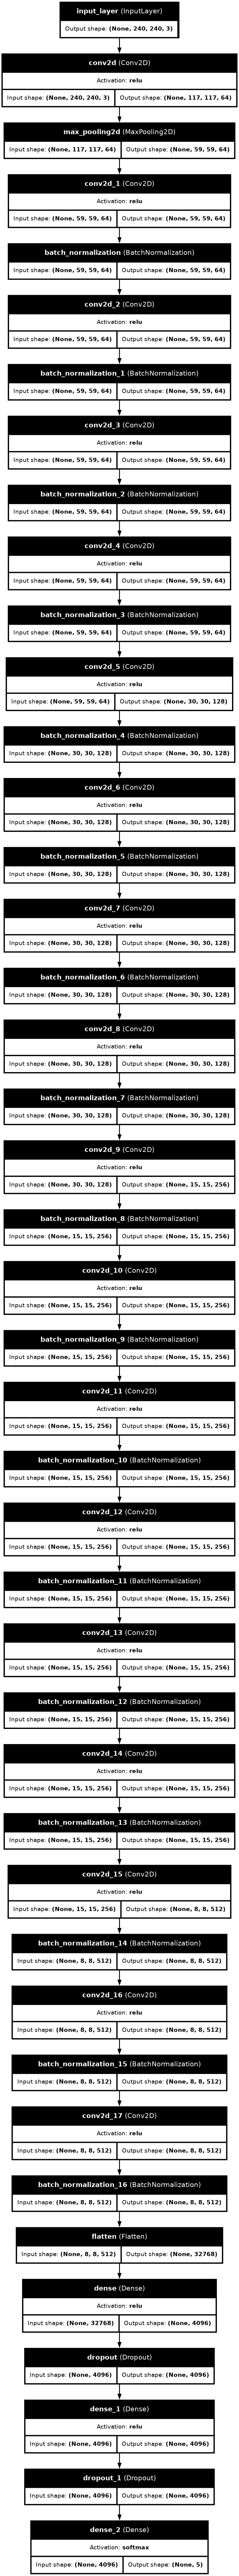

In [20]:
tf.keras.utils.plot_model(
    model_Res,
    to_file='res_model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=100
)

In [21]:
model_Res.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [22]:
RES_model = model_Res.fit(trainDataset, epochs=10, validation_data=valDataset)

Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1644s 13s/step - accuracy: 0.2799 - loss: 1.2471 - val_accuracy: 0.1862 - val_loss: 5.0253
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1614s 13s/step - accuracy: 0.3208 - loss: 0.5022 - val_accuracy: 0.2402 - val_loss: 4.7126
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1620s 13s/step - accuracy: 0.2739 - loss: 0.4847 - val_accuracy: 0.3147 - val_loss: 0.4413
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1608s 13s/step - accuracy: 0.3022 - loss: 0.4621 - val_accuracy: 0.2644 - val_loss: 0.7805
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1610s 13s/step - accuracy: 0.2567 - loss: 0.4848 - val_accuracy: 0.2756 - val_loss: 1.1793
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1646s 13s/step - accuracy: 0.2496 - loss: 0.4845 - val_accuracy: 0.3333 - val_loss: 0.4494
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1652s 13s/step - accuracy: 0.2821 - loss: 0.4688 - val_accuracy: 0.2737 - val_loss: 0.4781
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 1629s 13s/step - accuracy: 0.3101 - loss: 0

# ResNet Output Visualization

In [23]:
training_loss_res = RES_model.history['loss']
val_loss_res = RES_model.history['val_loss']
training_acc_res = RES_model.history['accuracy']
val_acc_res = RES_model.history['val_accuracy']

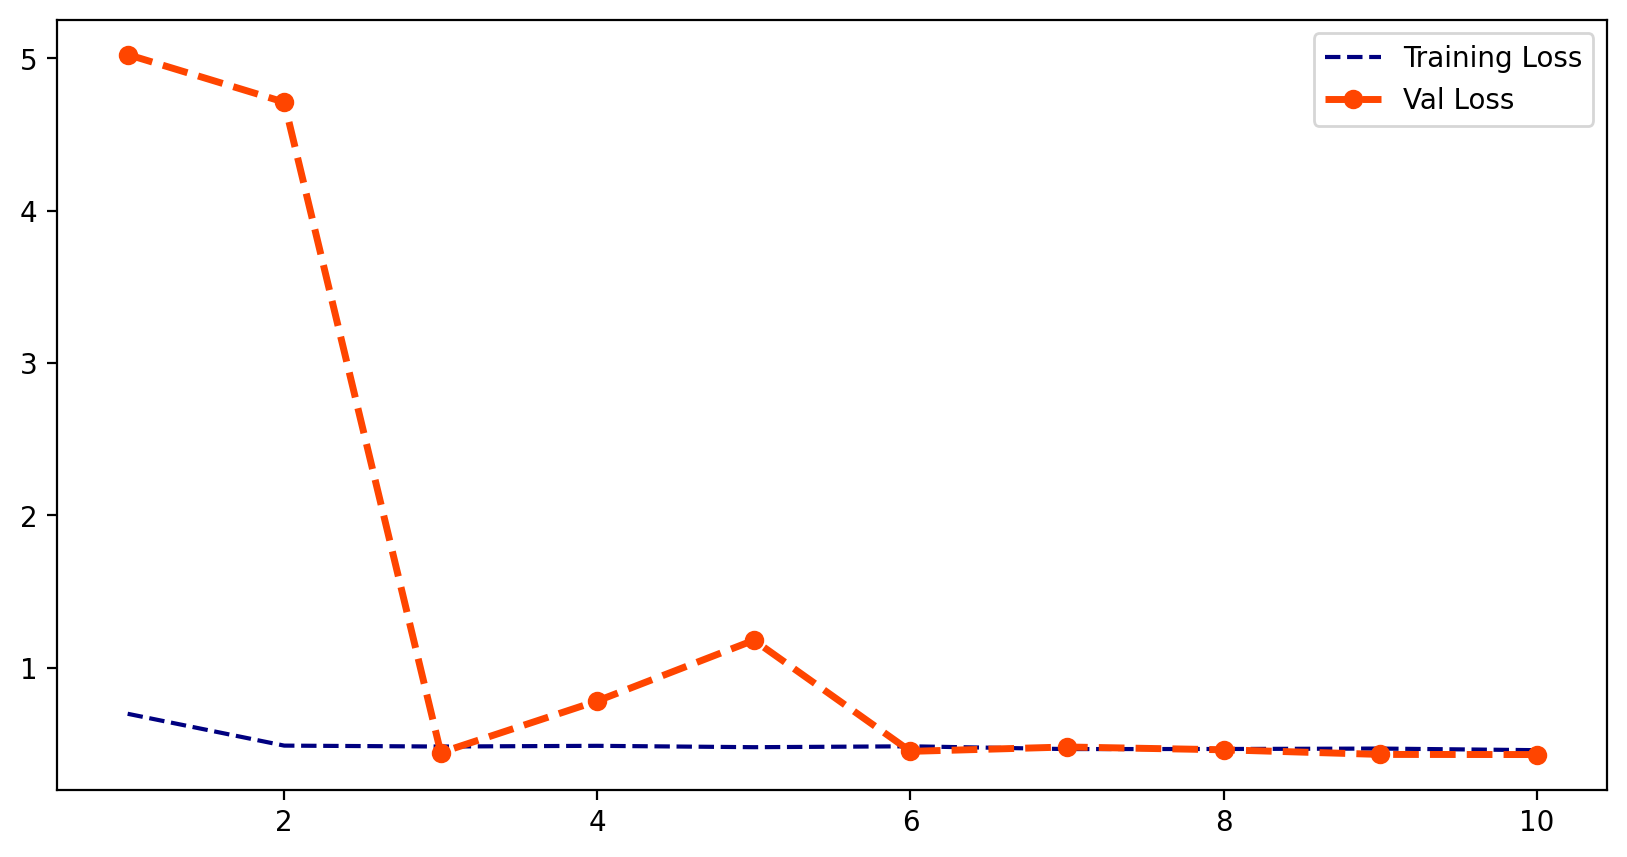

In [25]:

epoch_count = range(1, 11)  # Assuming you have 10 epochs


plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, training_loss_res, 'r--', color='navy')
plt.plot(epoch_count, val_loss_res, '--bo', color='orangered', linewidth=2.5, label='line with marker')
plt.legend(['Training Loss', 'Val Loss'])
plt.show()

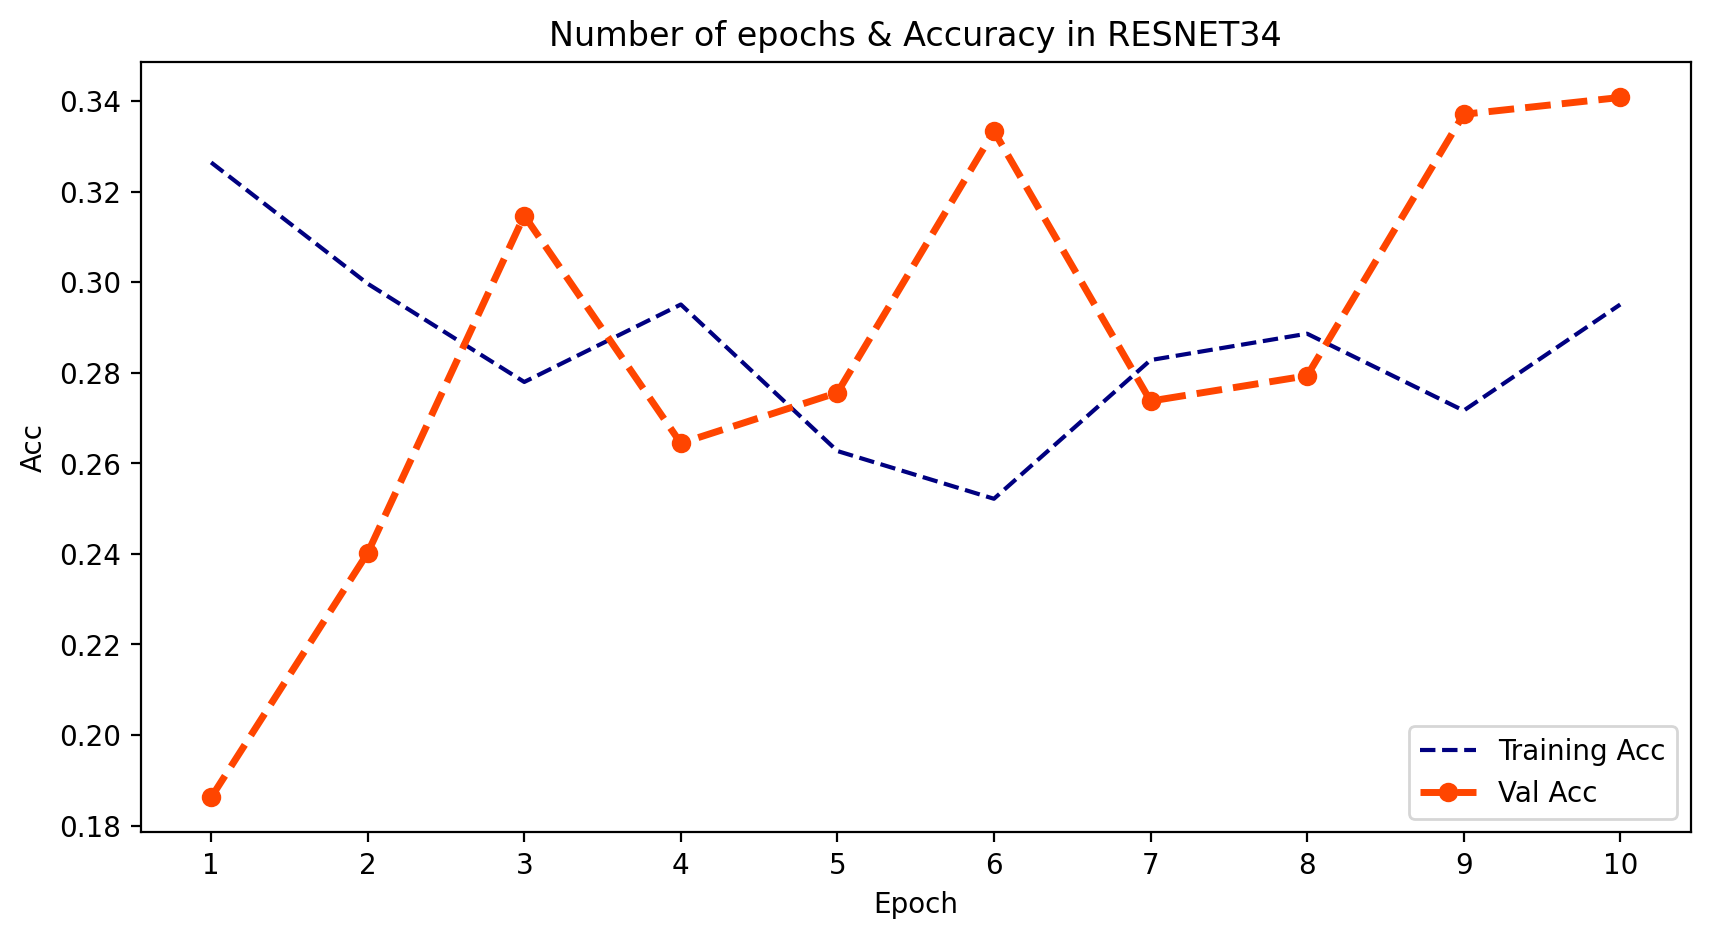

In [26]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(epoch_count, training_acc_res, 'r--', color= 'navy')
plt.plot(epoch_count, val_acc_res, '--bo',color= 'orangered', linewidth = '2.5', label='line with marker')
plt.legend(['Training Acc', 'Val Acc'])
plt.title('Number of epochs & Accuracy in RESNET34')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.xticks(np.arange(1,21,1))
plt.plot();
plt.show();